In [115]:
pip install geopy



   -------------------- ------------------- 1/2 [geopy]
   ---------------------------------------- 2/2 [geopy]

Note: you may need to restart the kernel to use updated packages.


In [116]:
# === Imports ===
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from geopy.distance import geodesic


In [ ]:
# Data Look up and Leeds filtering

import pandas as pd

# base_path directory
base_path = r"C:\Users\mayth\OneDrive - Leeds Beckett University\MS Data Science Modules\Dissertation\RTA Dataset\\"

# define look_up table
lookup_file = base_path + "dft-road-casualty-statistics-road-safety-open-dataset-data-guide-2024.xlsx"

# define the paths for the main datasets (collision, vehicle, and casualty)
files = {
    "collision": base_path + "dft-road-casualty-statistics-collision-last-5-years.csv",
    "vehicle": base_path + "dft-road-casualty-statistics-vehicle-last-5-years.csv",
    "casualty": base_path + "dft-road-casualty-statistics-casualty-last-5-years.csv"
}

# load the datasets from CSV into pandas dataframes
collision_df = pd.read_csv(files["collision"], low_memory=False)
vehicle_df = pd.read_csv(files["vehicle"], low_memory=False)
casualty_df = pd.read_csv(files["casualty"], low_memory=False)

# filter the collision data to only include rows where the district is Leeds
# Leeds district code is E08000035
leeds_collision_df = collision_df[collision_df['local_authority_ons_district'] == "E08000035"]

# accident index from main Leeds collision data
leeds_accidents = leeds_collision_df['accident_index'].unique()

# filter the vehicle and casualty datasets using the Leeds accident index
leeds_vehicle_df = vehicle_df[vehicle_df['accident_index'].isin(leeds_accidents)]
leeds_casualty_df = casualty_df[casualty_df['accident_index'].isin(leeds_accidents)]

# function to replace coded values with labels (look_up table)
def apply_lookups(df, dataset_name, lookup_excel):
    # Load the lookup table
    lookup_df = pd.read_excel(lookup_excel, sheet_name="2024_code_list")

    # filter to only the relevant codes for this dataset
    lookup_filtered = lookup_df[
        (lookup_df['table'] == dataset_name) &
        lookup_df['label'].notnull() &
        lookup_df['code/format'].notnull()
    ][['field name', 'code/format', 'label']]

    # apply the mapping
    for field in lookup_filtered['field name'].unique():
        if field in df.columns:
            code_map = lookup_filtered[lookup_filtered['field name'] == field].set_index('code/format')['label'].to_dict()
            # Use .loc to safely update the column
            df.loc[:, field] = df[field].map(code_map)

    return df


# apply the lookups to clean the Leeds datasets
leeds_collision_after_lookup = apply_lookups(leeds_collision_df, "accident", lookup_file)
leeds_vehicle_after_lookup = apply_lookups(leeds_vehicle_df, "vehicle", lookup_file)
leeds_casualty_after_lookup = apply_lookups(leeds_casualty_df, "casualty", lookup_file)

# save the cleaned Leeds datasets to new CSV files
leeds_collision_after_lookup.to_csv(base_path + "leeds_collision_after_lookup.csv", index=False)
leeds_vehicle_after_lookup.to_csv(base_path + "leeds_vehicle_after_lookup.csv", index=False)
leeds_casualty_after_lookup.to_csv(base_path + "leeds_casualty_after_lookup.csv", index=False)

# successful message
print("All Leeds datasets filtered by local authority code and cleaned successfully.")


In [22]:
# Leeds Collision Data Summary
print("Leeds Collision Data (Looked up)")
print(leeds_collision_after_lookup.head(), "\n")
print("Shape:", leeds_collision_after_lookup.shape)
print("Columns:", leeds_collision_after_lookup.columns.tolist())
print("Missing values:\n", leeds_collision_after_lookup.isnull().sum(), "\n")

# Leeds Vehicle Data Summary
print("Leeds Vehicle Data (Looked up)")
print(leeds_vehicle_after_lookup.head(), "\n")
print("Shape:", leeds_vehicle_after_lookup.shape)
print("Columns:", leeds_vehicle_after_lookup.columns.tolist())
print("Missing values:\n", leeds_vehicle_after_lookup.isnull().sum(), "\n")

# Leeds Casualty Data Summary
print("Leeds Casualty Data (Looked up)")
print(leeds_casualty_after_lookup.head(), "\n")
print("Shape:", leeds_casualty_after_lookup.shape)
print("Columns:", leeds_casualty_after_lookup.columns.tolist())
print("Missing values:\n", leeds_casualty_after_lookup.isnull().sum(), "\n")


Leeds Collision Data (Looked up)
      accident_index  accident_year accident_reference  location_easting_osgr  \
41052  2019131901350           2019          131901350               443576.0   
41053  20191358F1730           2019          1358F1730               436147.0   
41055  2019136111190           2019          136111190               435904.0   
41057  2019136111674           2019          136111674               423194.0   
41058  2019136111836           2019          136111836               429149.0   

       location_northing_osgr  longitude   latitude    police_force  \
41052                438198.0  -1.339288  53.838231  West Yorkshire   
41053                434957.0  -1.452556  53.809670  West Yorkshire   
41055                425850.0  -1.457300  53.727837  West Yorkshire   
41057                438111.0  -1.649019  53.838752  West Yorkshire   
41058                431736.0  -1.559127  53.781158  West Yorkshire   

      accident_severity  number_of_vehicles  ...     

In [24]:
# General overview of numeric and categorical fields
print("Leeds Collision Summary Stats:")
print(leeds_collision_after_lookup.describe(include='all'), "\n")

print("Leeds Vehicle Summary Stats:")
print(leeds_vehicle_after_lookup.describe(include='all'), "\n")

print("Leeds Casualty Summary Stats:")
print(leeds_casualty_after_lookup.describe(include='all'), "\n")


Leeds Collision Summary Stats:
       accident_index  accident_year accident_reference  \
count            6900    6900.000000               6900   
unique           6900            NaN               6900   
top     2023132300299            NaN          132300299   
freq                1            NaN                  1   
mean              NaN    2021.087246                NaN   
std               NaN       1.434742                NaN   
min               NaN    2019.000000                NaN   
25%               NaN    2020.000000                NaN   
50%               NaN    2021.000000                NaN   
75%               NaN    2022.000000                NaN   
max               NaN    2023.000000                NaN   

        location_easting_osgr  location_northing_osgr    longitude  \
count             6900.000000             6900.000000  6900.000000   
unique                    NaN                     NaN          NaN   
top                       NaN                     

In [29]:
# Cleaning look_up leeds data
import pandas as pd
import numpy as np

# base_path directory
base_path = r"C:\Users\mayth\OneDrive - Leeds Beckett University\MS Data Science Modules\Dissertation\RTA Dataset\\"

# files after look up
collision_file = base_path + "leeds_collision_after_lookup.csv"
vehicle_file = base_path + "leeds_vehicle_after_lookup.csv"
casualty_file = base_path + "leeds_casualty_after_lookup.csv"

# load the data
collision_df = pd.read_csv(collision_file, low_memory=False)
vehicle_df = pd.read_csv(vehicle_file, low_memory=False)
casualty_df = pd.read_csv(casualty_file, low_memory=False)

# --- Clean Collision Data ---

# drop unused or mostly empty columns
collision_df.drop(columns=[
    'speed_limit', 
    'carriageway_hazards', 
    'special_conditions_at_site'
], errors='ignore', inplace=True)

# replace -1 with NaN (if still present)
collision_df['enhanced_severity_collision'] = collision_df['enhanced_severity_collision'].replace(-1, np.nan)

# convert 'date' to datetime
collision_df['date'] = pd.to_datetime(collision_df['date'], errors='coerce', dayfirst=True)

# extract hour from 'time'
collision_df['hour'] = pd.to_datetime(collision_df['time'], format='%H:%M', errors='coerce').dt.hour

# save cleaned collision file
collision_df.to_csv(base_path + "leeds_collision_final.csv", index=False)

# --- Clean Vehicle Data ---

# drop irrelevant or mostly missing columns
vehicle_df.drop(columns=[
    'dir_to_n', 'dir_to_e', 'dir_from_n', 'dir_from_e',
    'generic_make_model', 'engine_capacity_cc', 'age_of_driver',
    'skidding_and_overturning', 'hit_object_in_carriageway', 'hit_object_off_carriageway'
], errors='ignore', inplace=True)

# save cleaned vehicle file
vehicle_df.to_csv(base_path + "leeds_vehicle_final.csv", index=False)

# --- Clean Casualty Data ---

# drop column if mostly null
casualty_df.drop(columns=['age_of_casualty'], errors='ignore', inplace=True)

# Fix misinterpreted age bands due to date formatting
casualty_df['age_band_of_casualty'] = casualty_df['age_band_of_casualty'].replace({
    '06-Oct': '6 - 10',
    'Nov-15': '11 - 15'
})

# save cleaned casualty file
casualty_df.to_csv(base_path + "leeds_casualty_final.csv", index=False)

# successful message
print("Cleaned datasets saved")


Cleaned datasets saved


In [30]:
# load the cleaned files
collision_final = pd.read_csv(base_path + "leeds_collision_final.csv", low_memory=False)
vehicle_final = pd.read_csv(base_path + "leeds_vehicle_final.csv", low_memory=False)
casualty_final = pd.read_csv(base_path + "leeds_casualty_final.csv", low_memory=False)

# Print the shape (rows, columns)
print("leeds_collision_final.csv shape:", collision_final.shape)
print("leeds_vehicle_final.csv shape:", vehicle_final.shape)
print("leeds_casualty_final.csv shape:", casualty_final.shape)


leeds_collision_final.csv shape: (6900, 35)
leeds_vehicle_final.csv shape: (12673, 24)
leeds_casualty_final.csv shape: (8883, 20)


In [32]:
# For EDA
# Load Libraries & Data

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Styling
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# Load cleaned final datasets
base_path = r"C:\Users\mayth\OneDrive - Leeds Beckett University\MS Data Science Modules\Dissertation\RTA Dataset\\"

collision_df = pd.read_csv(base_path + "leeds_collision_final.csv")
vehicle_df = pd.read_csv(base_path + "leeds_vehicle_final.csv")
casualty_df = pd.read_csv(base_path + "leeds_casualty_final.csv")


C:\Users\mayth\AppData\Local\Temp\ipykernel_12428\3418069932.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=collision_df, x='year', palette='Blues_d')


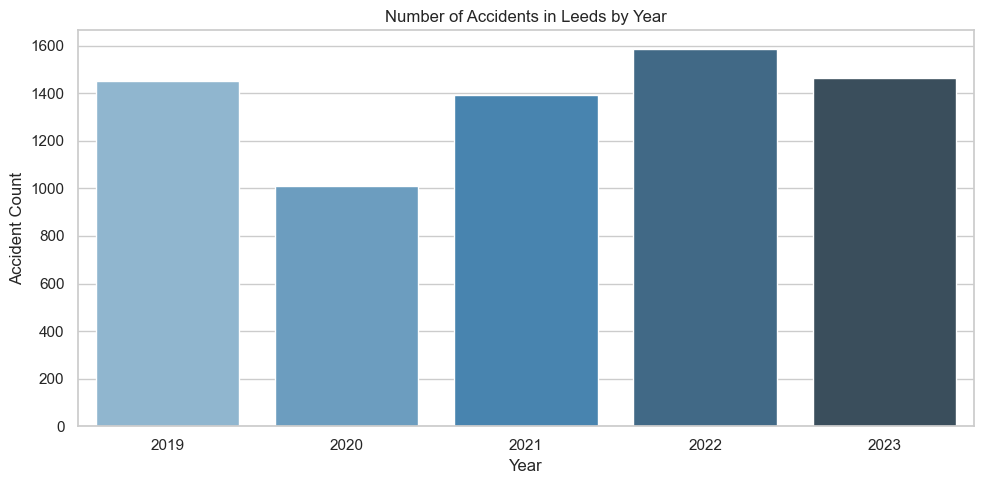

In [33]:
# EDA
# Number of Accidents in Leeds by Year (Bar Chart)

collision_df['date'] = pd.to_datetime(collision_df['date'], errors='coerce')
collision_df['year'] = collision_df['date'].dt.year

sns.countplot(data=collision_df, x='year', palette='Blues_d')
plt.title("Number of Accidents in Leeds by Year")
plt.xlabel("Year")
plt.ylabel("Accident Count")
plt.tight_layout()
plt.show()


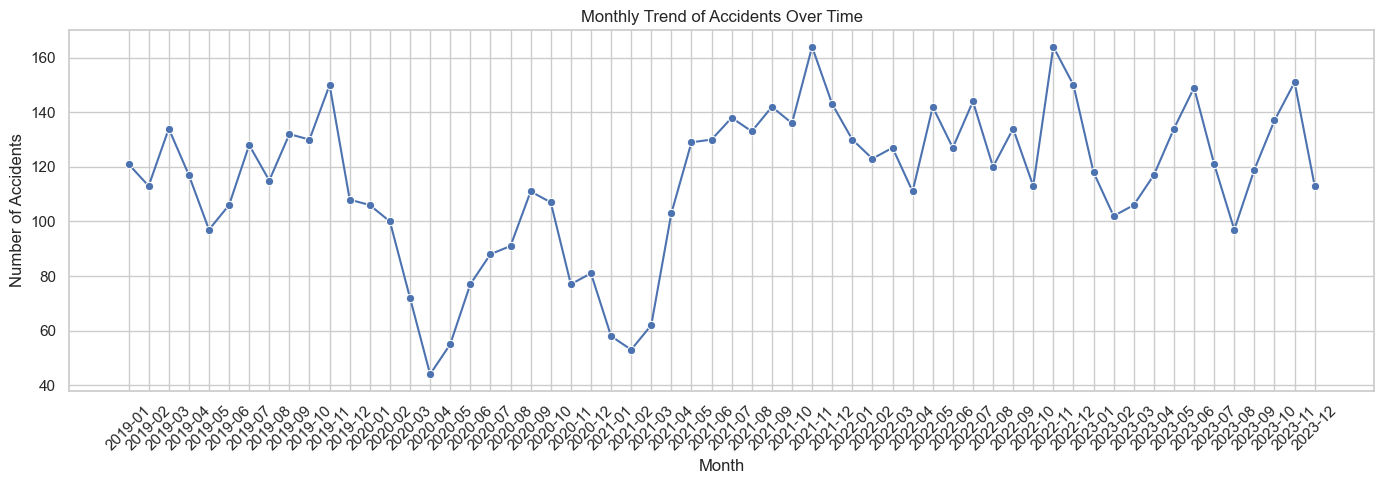

In [40]:
# EDA
# Monthly Trend of Accidents Over Time

collision_df['month'] = collision_df['date'].dt.to_period('M')

# Count number of accidents per month
monthly_trend = collision_df.groupby('month').size().reset_index(name='accidents')
monthly_trend['month'] = monthly_trend['month'].astype(str)

plt.figure(figsize=(14, 5))
sns.lineplot(data=monthly_trend, x='month', y='accidents', marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Trend of Accidents Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()


C:\Users\mayth\AppData\Local\Temp\ipykernel_12428\3108744384.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=plot_df, x='age_band_of_casualty', order=plot_df['age_band_of_casualty'].value_counts().index, palette='muted')


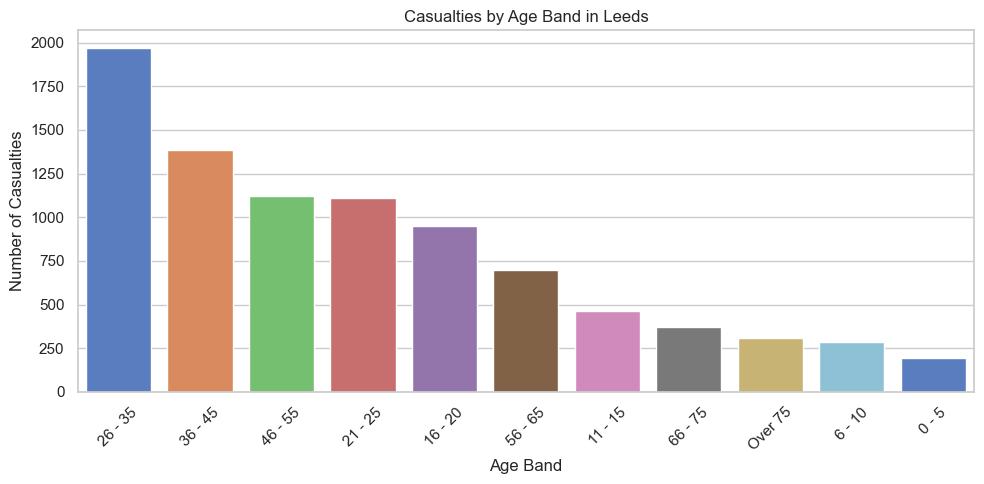

In [77]:
# EDA
# Casualties by Age Band

plot_df = full_df[full_df['age_band_of_casualty'] != 'Data missing or out of range']

sns.countplot(data=plot_df, x='age_band_of_casualty', order=plot_df['age_band_of_casualty'].value_counts().index, palette='muted')
plt.title("Casualties by Age Band in Leeds")
plt.xlabel("Age Band")
plt.ylabel("Number of Casualties")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\mayth\AppData\Local\Temp\ipykernel_12428\2578952270.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_vehicles.values, y=top_vehicles.index, palette='Set2')


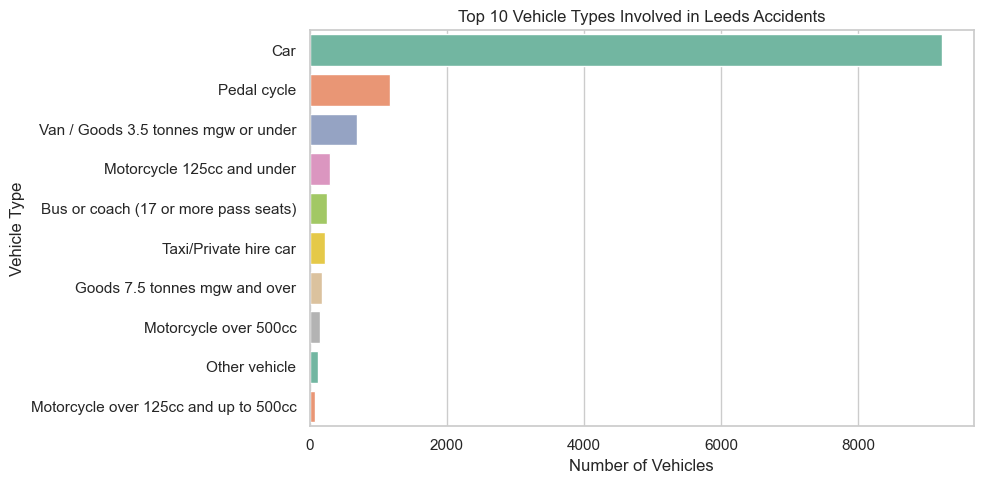

In [35]:
# EDA
# Vehicle Types Involved in Accidents (Top 10)

top_vehicles = vehicle_df['vehicle_type'].value_counts().nlargest(10)

sns.barplot(x=top_vehicles.values, y=top_vehicles.index, palette='Set2')
plt.title("Top 10 Vehicle Types Involved in Leeds Accidents")
plt.xlabel("Number of Vehicles")
plt.ylabel("Vehicle Type")
plt.tight_layout()
plt.show()


C:\Users\mayth\AppData\Local\Temp\ipykernel_12428\3302240915.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=collision_df, x='accident_severity', order=collision_df['accident_severity'].value_counts().index, palette='coolwarm')


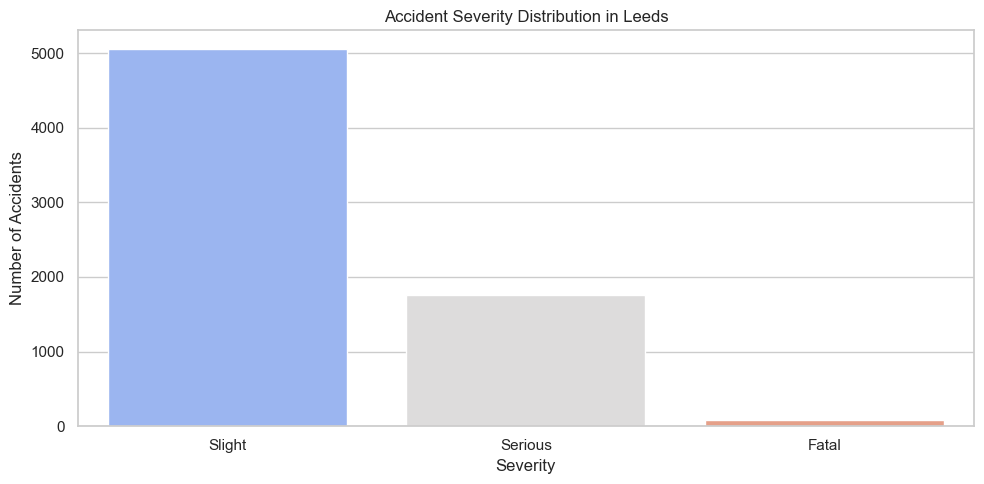

In [37]:
# EDA
# Accident Severity Distribution in Leeds

sns.countplot(data=collision_df, x='accident_severity', order=collision_df['accident_severity'].value_counts().index, palette='coolwarm')
plt.title("Accident Severity Distribution in Leeds")
plt.xlabel("Severity")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()


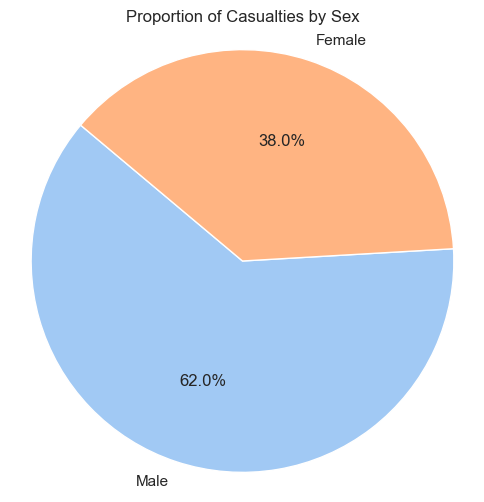

In [73]:
# EDA
# Count casualties by sex
sex_counts = full_df[full_df['sex_of_casualty'] != 'Data missing or out of range']['sex_of_casualty'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title("Proportion of Casualties by Sex")
plt.axis('equal')  # Equal aspect ratio ensures a circle
plt.show()


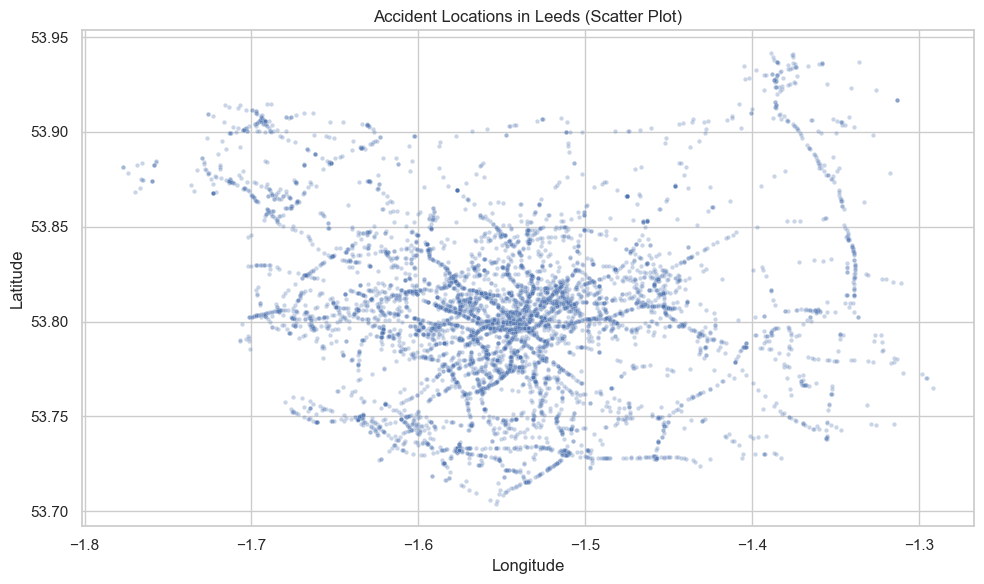

In [41]:
# EDA
# Accident Locations in Leeds (Scatter Plot)

# Drop rows with missing coordinates
map_data = collision_df.dropna(subset=['latitude', 'longitude'])

# Plot points
plt.figure(figsize=(10, 6))
sns.scatterplot(data=map_data, x='longitude', y='latitude', alpha=0.3, s=10)
plt.title("Accident Locations in Leeds (Scatter Plot)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


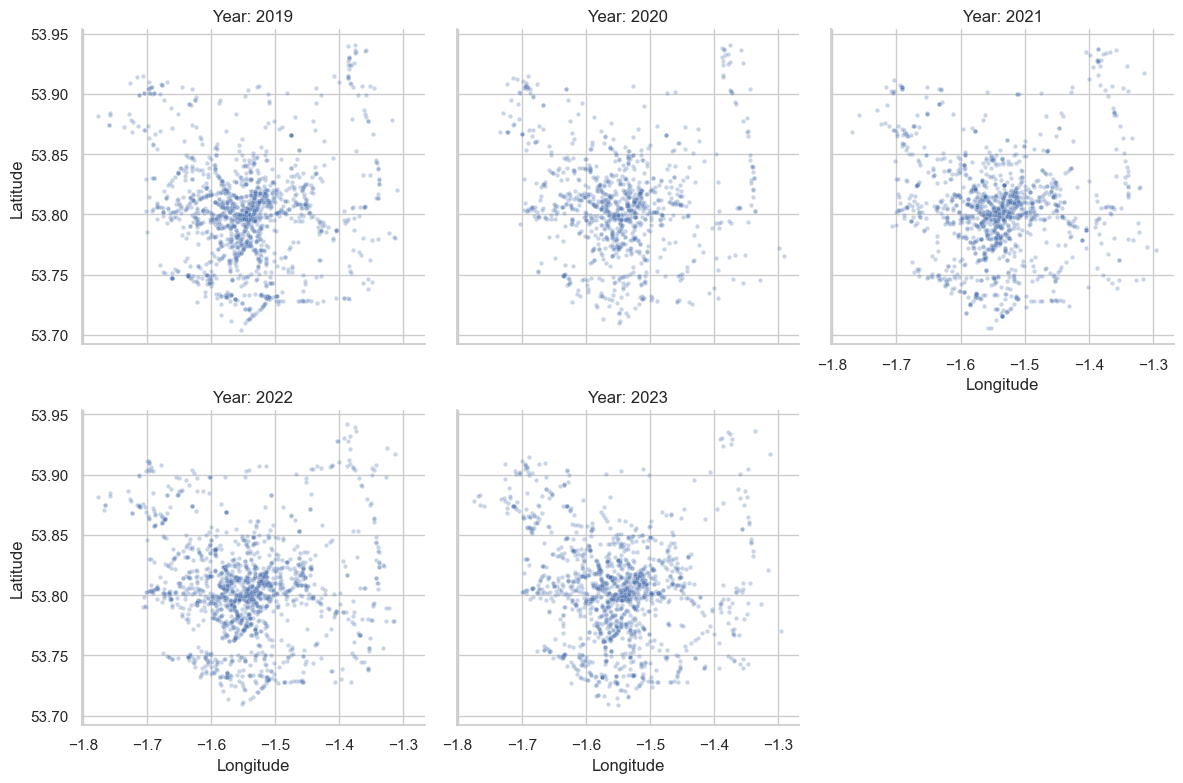

In [70]:
# EDA
# Accident Locations in Leeds by Year

import seaborn as sns
import matplotlib.pyplot as plt

# Make sure 'year' column exists and is of type int or str
map_data['year'] = map_data['date'].dt.year

# Create FacetGrid
g = sns.FacetGrid(map_data, col='year', col_wrap=3, height=4)
g.map_dataframe(sns.scatterplot, x='longitude', y='latitude', alpha=0.3, s=10)
g.set_titles("Year: {col_name}")
g.set_axis_labels("Longitude", "Latitude")
plt.tight_layout()
plt.show()


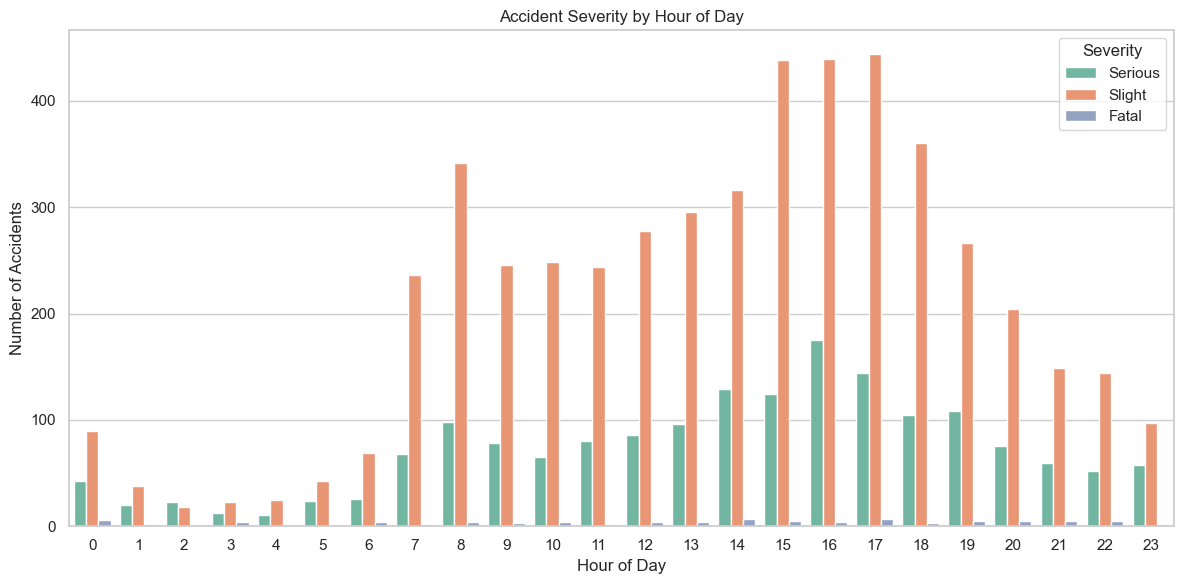

In [43]:
# EDA
# Accident Severity by Hour of Day

collision_df['hour'] = pd.to_datetime(collision_df['time'], format='%H:%M', errors='coerce').dt.hour

plt.figure(figsize=(12, 6))
sns.countplot(data=collision_df, x='hour', hue='accident_severity', palette='Set2')
plt.title("Accident Severity by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Accidents")
plt.legend(title="Severity")
plt.tight_layout()
plt.show()


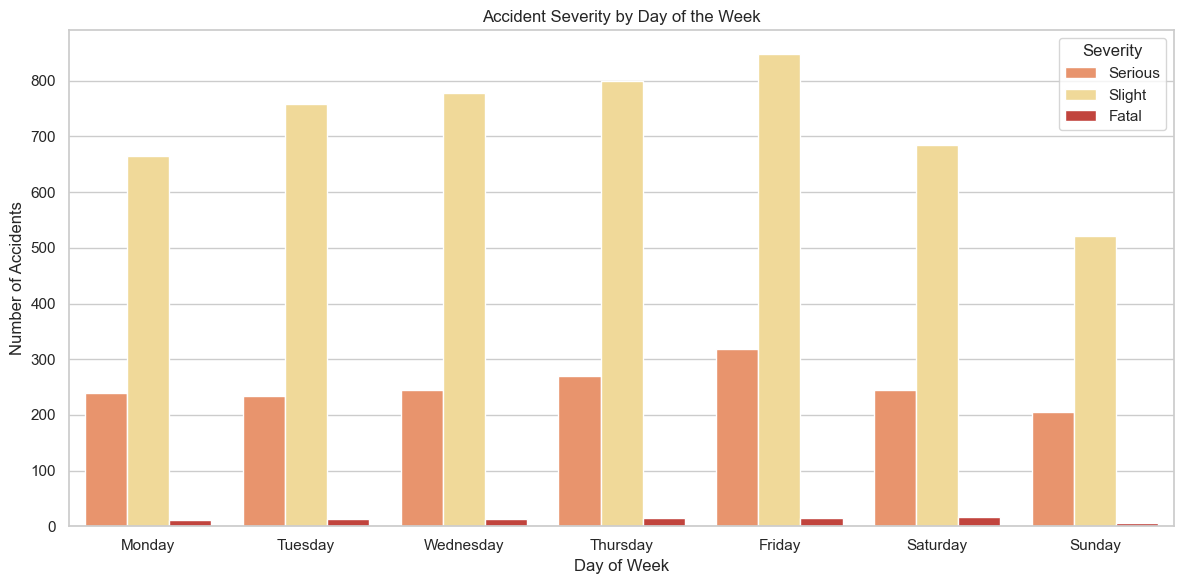

In [90]:
# EDA
# Accident Severity by Day of Week

collision_df['date'] = pd.to_datetime(collision_df['date'], errors='coerce')

collision_df['weekday'] = collision_df['date'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

severity_palette = {
    'Fatal': '#d73027',    # deep red
    'Serious': '#fc8d59',  # orange
    'Slight': '#fee08b'    # light yellow
}

plt.figure(figsize=(12, 6))
sns.countplot(data=collision_df, x='weekday', hue='accident_severity', order=weekday_order, palette=severity_palette)
plt.title("Accident Severity by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Accidents")
plt.legend(title="Severity")
plt.tight_layout()
plt.show()


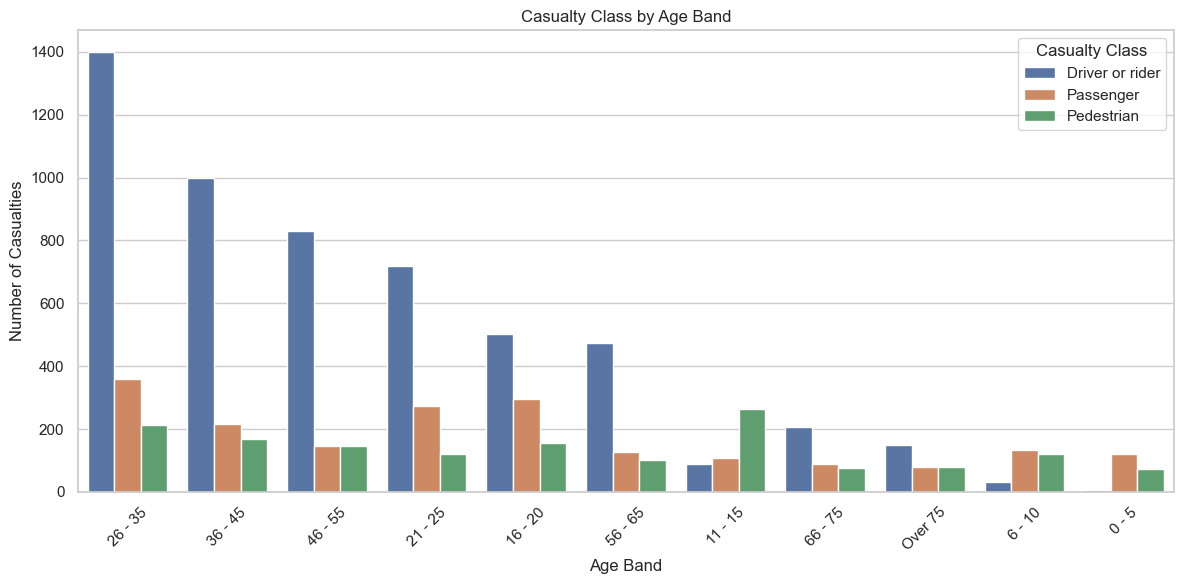

In [93]:
# EDA
# Casualty Class by Age Band

plot_df = full_df[full_df['age_band_of_casualty'] != 'Data missing or out of range']

plt.figure(figsize=(12, 6))
sns.countplot(data=plot_df, x='age_band_of_casualty', hue='casualty_class', order=plot_df['age_band_of_casualty'].value_counts().index)
plt.title("Casualty Class by Age Band")
plt.xlabel("Age Band")
plt.ylabel("Number of Casualties")
plt.legend(title="Casualty Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [102]:
# Merge accident data with open meteo weather dataset

import pandas as pd

# base_path
base_path = r"C:\Users\mayth\OneDrive - Leeds Beckett University\MS Data Science Modules\Dissertation\RTA Dataset\\"

# load the Leeds collision dataset
collision_df = pd.read_csv(base_path + "leeds_collision_final.csv", low_memory=False)

# load the weather dataset (gonna skip first description row)
weather_df = pd.read_csv(base_path + "weather dataset_open-meteo-53.81N1.56W48m.csv", skiprows=1)

# rename weather columns for easier access
weather_df.columns = [
    'time', 'temperature', 'dew_point', 'apparent_temp',
    'precipitation', 'rain', 'snowfall', 'snow_depth',
    'wind_speed', 'weather_code', 'sunshine_duration', 'is_day'
]

# convert 'time' in weather to datetime
weather_df['time'] = pd.to_datetime(weather_df['time'], errors='coerce')

# extract date and hour from weather data
weather_df['date'] = weather_df['time'].dt.date
weather_df['hour'] = weather_df['time'].dt.hour

# remove any weather rows with invalid time
weather_df.dropna(subset=['time'], inplace=True)

# convert collision date to datetime and extract date
collision_df['date'] = pd.to_datetime(collision_df['date'], errors='coerce').dt.date

# ensure 'hour' is numeric in collision data
collision_df['hour'] = pd.to_numeric(collision_df['hour'], errors='coerce')

# merge collision and weather data on 'date' and 'hour'
merged_df = pd.merge(collision_df, weather_df, on=['date', 'hour'], how='left')

# save the merged dataset
merged_df.to_csv(base_path + "leeds_collision_with_weather.csv", index=False)

print("Merged dataset saved as leeds_collision_with_weather.csv")


Merged dataset saved as leeds_collision_with_weather.csv


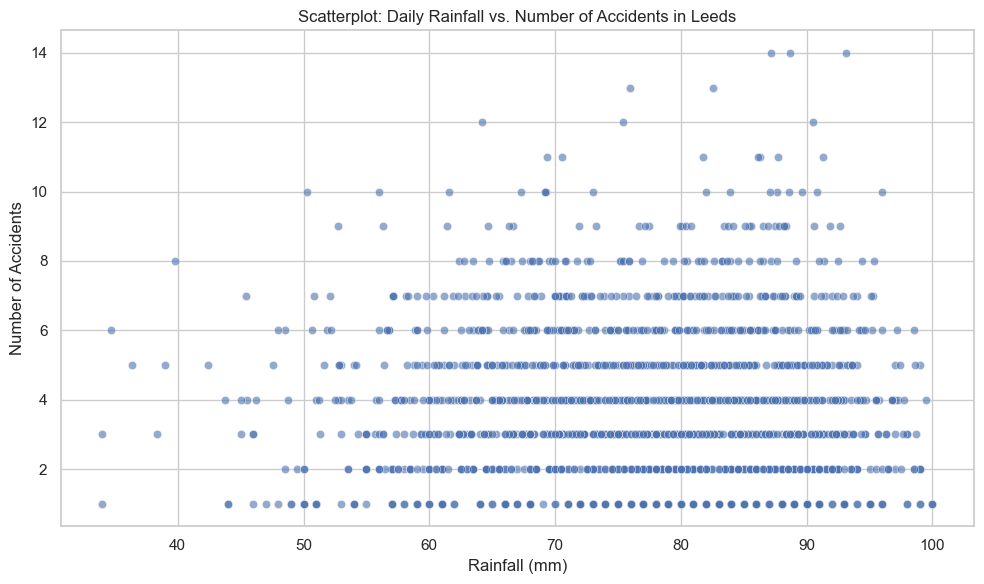

In [100]:
# EDA
# Scatterplot of Daily Rainfall vs. Accidents

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure 'date' is in datetime format
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')

# Group by date to get total accidents and average rain per day
daily_summary = merged_df.groupby('date').agg({
    'accident_index': 'count',
    'rain': 'mean'
}).reset_index()

# Rename columns for clarity
daily_summary.rename(columns={'accident_index': 'num_accidents'}, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=daily_summary, x='rain', y='num_accidents', alpha=0.6)
plt.title("Scatterplot: Daily Rainfall vs. Number of Accidents in Leeds")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Number of Accidents")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\mayth\AppData\Local\Temp\ipykernel_12428\2277197189.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x='sun_band', palette='Pastel1')


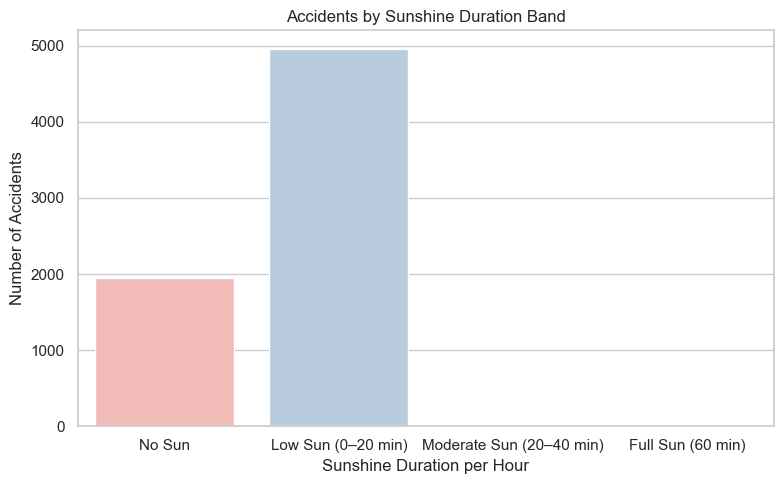

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# to make sure sunshine_duration and relevant weather columns are numeric
merged_df['sunshine_duration'] = pd.to_numeric(merged_df['sunshine_duration'], errors='coerce')

# 1. Bin Sunshine Duration
# Convert from seconds to minute
merged_df['sunshine_minutes'] = merged_df['sunshine_duration'] / 60

# Create sunshine bands
merged_df['sun_band'] = pd.cut(
    merged_df['sunshine_duration'],
    bins=[-1, 0, 1200, 2400, 3600],
    labels=['No Sun', 'Low Sun (0–20 min)', 'Moderate Sun (20–40 min)', 'Full Sun (60 min)'],
    include_lowest=True
)

# 2. Visualize Accidents by Sunshine Band
plt.figure(figsize=(8, 5))
sns.countplot(data=merged_df, x='sun_band', palette='Pastel1')
plt.title("Accidents by Sunshine Duration Band")
plt.xlabel("Sunshine Duration per Hour")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()



In [110]:
import pandas as pd
import glob
import os

# data_dir
data_dir = r"C:\Users\mayth\OneDrive - Leeds Beckett University\MS Data Science Modules\Dissertation\RTA Dataset"

# Load all relevant CSVs
e0_files = sorted(glob.glob(os.path.join(data_dir, "E0*.csv")))
e1_files = sorted(glob.glob(os.path.join(data_dir, "E1*.csv")))

df_e0_all = pd.concat([pd.read_csv(f) for f in e0_files], ignore_index=True)
df_e1_all = pd.concat([pd.read_csv(f) for f in e1_files], ignore_index=True)

# Combine and Filter by Year
df_all = pd.concat([df_e0_all, df_e1_all], ignore_index=True)
df_all['Date'] = pd.to_datetime(df_all['Date'], errors='coerce', dayfirst=True)
df_all = df_all[df_all['Date'].dt.year.between(2019, 2023)]

# Leeds United Home Matches
df_leeds = df_all[df_all['HomeTeam'] == "Leeds"].copy()

# Remove 2019 Leeds matches with missing Time
df_leeds = df_leeds[~((df_leeds['Date'].dt.year == 2019) & (df_leeds['Time'].isna()))]

# Add Stadium Location
df_leeds["Stadium"] = "Elland Road"
df_leeds["City"] = "Leeds"
df_leeds["Latitude"] = 53.7775
df_leeds["Longitude"] = -1.5722

# STEP 6: Combine Date and Time
df_leeds["MatchDateTime"] = pd.to_datetime(
    df_leeds["Date"].astype(str) + " " + df_leeds["Time"].astype(str),
    errors='coerce'
)

# Select Columns and Save
final_df = df_leeds[[ 
    "Date", "Time", "MatchDateTime", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR",
    "Stadium", "City", "Latitude", "Longitude"
]]

# Save the output
output_path = os.path.join(data_dir, "leeds_home_matches_2019_2023.csv")
final_df.to_csv(output_path, index=False)

print(f"Saved: {output_path}")


Saved: C:\Users\mayth\OneDrive - Leeds Beckett University\MS Data Science Modules\Dissertation\RTA Dataset\leeds_home_matches_2019_2023.csv
